7 : condition met: stop  when time = 1e-07
doAnalyses: pause requested
tran simulation interrupted
8 : condition met: stop  when time = 2e-07
doAnalyses: pause requested
simulation interrupted
9 : condition met: stop  when time = 3e-07
doAnalyses: pause requested
simulation interrupted


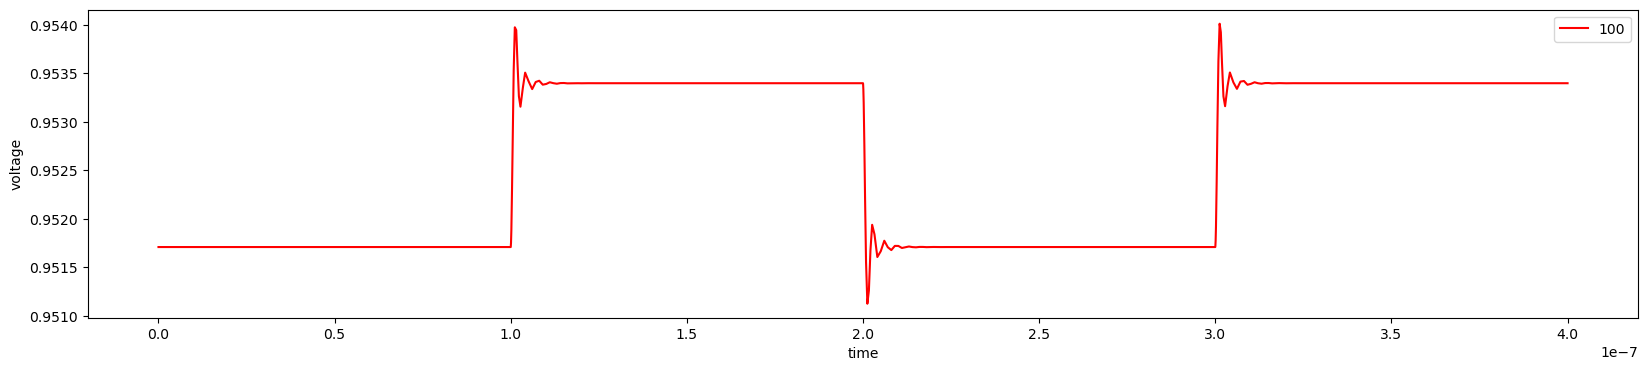

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PySpice.Spice.NgSpice.Shared import NgSpiceShared

#创建NgSpiceShared对象
ngspice = NgSpiceShared.new_instance()
#读取电路文件
with open('mypdn.cir') as f:
    circuit=f.read()
#导入电路
ngspice.load_circuit(circuit)

#根据spice的断点执行规则，
# 1、首先设置好仿真时的断点时间
# 2、开始仿真
# 3、在仿真中途会在设置好的时间中断仿真，此时可以进行一些指令，最后执行resume指令继续仿真，直到下一个断点或终点

#设置断点，每100ns设置一个断点
for i in range(1,4):
    time_stop=100
    ngspice.stop('time = '+str(time_stop*i)+'n')

#开始仿真
#由于pyspice总是在stop时报错command error，但实际没有问题，所以使用try except保证后续代码继续执行
try:
    ngspice.exec_command('tran 1n 400n')
except:
    pass

#当中断时执行的指令
for i in range(1,4):
    #更换负载
    if i%2==1:
        ngspice.alter_device('r1000000001_1000000002',resistance=10)
    else:
        ngspice.alter_device('r1000000001_1000000002',resistance=1)
    #由于pyspice总是在stop时报错command error，所以使用try except保证后续代码继续执行
    try:
        ngspice.resume(background=False)
    except:
        pass

#获取仿真结果
plots = ngspice.plot(simulation=None, plot_name=ngspice.last_plot)
analysis=plots.to_analysis()
#绘制图像
fig=plt.figure(figsize=(20,4))
plt.plot(np.array(analysis.time),np.array(analysis["100"]), label="100",color='red')
plt.legend()
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()
fig.savefig("./figure/V100.png",dpi=300)
plt.close()

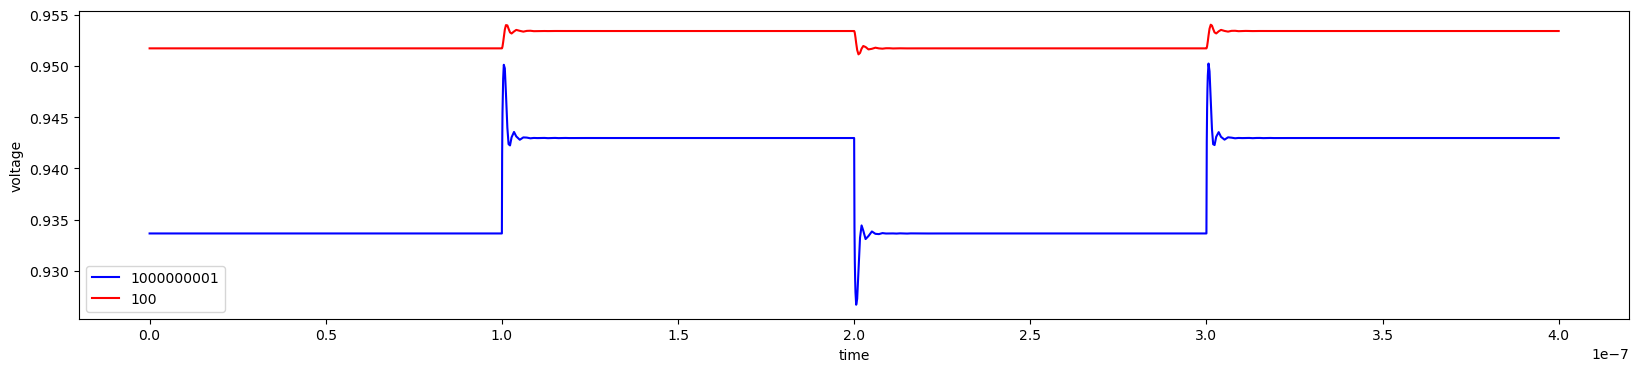

In [6]:
fig=plt.figure(figsize=(20,4))
#plt.plot(np.array(analysis.time),np.array(analysis["1000000002"]), label="1000000002",color='black')
plt.plot(np.array(analysis.time),np.array(analysis["1000000001"]), label="1000000001",color='blue')
plt.plot(np.array(analysis.time),np.array(analysis["100"]), label="100",color='red')
plt.legend()
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()
fig.savefig("./figure/V100-V1000000001.png",dpi=300)